# MRI Görüntülerinden Beyin Tümörü Sınıflandırması

## Derin Öğrenme (FET312) - Final Proje Kod Dosyası

**Öğrenci:** Muhammed Emin Benzer  
**Grup:** DevTe213  
**Hedef Model:** ResNet50 (Residual Networks)  

### Model Stratejisi: Transfer Learning ve Residual Bağlantılar
Bu notebook dosyasında, derin ağlarda sıkça karşılaşılan **"Kaybolan Gradyan" (Vanishing Gradient)** problemini *Skip Connections (Atlamalı Bağlantılar)* ile çözen **ResNet50** mimarisi kullanılmıştır.

**Uygulanan Yöntem:**
1.  **Transfer Learning:** ImageNet üzerinde eğitilmiş ağırlıklar kullanılarak modelin görsel algısı projeye aktarılmıştır.
2.  **Feature Extraction (Dondurma):** Modelin konvolüsyon katmanları dondurulmuş (`requires_grad=False`), böylece mevcut özellik çıkarıcı yetenek korunmuştur.
3.  **Fine-Tuning:** Sadece son sınıflandırma katmanı (Fully Connected Layer) projemizdeki 4 sınıf (Glioma, Meningioma, Pituitary, No Tumor) için yeniden eğitilmiştir.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import time
import copy
import os
import gc
import json

# Hafiza Temizligi
gc.collect()
torch.cuda.empty_cache()

# Ayarlar
BATCH_SIZE = 16 
IMG_SIZE = 224
LEARNING_RATE = 0.001
EPOCHS = 20
RANDOM_SEED = 213

# Seed Sabitleme
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)

# Cihaz Secimi
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Cihaz: {device}")

Cihaz: cuda


In [2]:
DATA_PATH = r"C:\Users\ArdaOlmez\Desktop\others\projects\python\datasets\brain_tumor_dataset-2\training"

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

try:
    full_dataset = datasets.ImageFolder(DATA_PATH, transform=data_transforms['train'])
    
    total_len = len(full_dataset)
    train_len = int(0.7 * total_len)
    val_len = int(0.15 * total_len)
    test_len = total_len - train_len - val_len

    train_data, val_data, test_data = torch.utils.data.random_split(
        full_dataset, [train_len, val_len, test_len],
        generator=torch.Generator().manual_seed(RANDOM_SEED)
    )

    dataloaders = {
        'train': DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=0),
        'val': DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=0),
        'test': DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    }
    
    print("-" * 30)
    print("VERI SETI BILGILERI")
    print("-" * 30)
    print(f"Toplam Goruntu Sayisi: {total_len}")
    print(f"Egitim Seti (Train)  : {len(train_data)}")
    print(f"Dogrulama Seti (Val) : {len(val_data)}")
    print(f"Test Seti (Test)     : {len(test_data)}")
    print(f"Sinif Isimleri       : {full_dataset.classes}")
    print("-" * 30)

except Exception as e:
    print(f"HATA: {e}")

------------------------------
VERI SETI BILGILERI
------------------------------
Toplam Goruntu Sayisi: 5712
Egitim Seti (Train)  : 3998
Dogrulama Seti (Val) : 856
Test Seti (Test)     : 858
Sinif Isimleri       : ['glioma', 'meningioma', 'notumor', 'pituitary']
------------------------------


In [3]:
print("Model hazirlaniyor...")
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# Katmanlari Dondur
for param in model.parameters():
    param.requires_grad = False

# Siniflandirici Katmani Degistir
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)
model = model.to(device)

print("Model GPU uzerine alindi.")

Model hazirlaniyor...
Model GPU uzerine alindi.


In [4]:
optimizer = optim.Adam(model.fc.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

since = time.time() # Baslangic zamani
best_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())

# Sonuclari tutacagimiz sozluk
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

print(f"Egitim Basliyor... (20 Epoch)")

for epoch in range(EPOCHS):
    # Her epoch basinda hafiza temizligi
    gc.collect()
    torch.cuda.empty_cache()
    
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
        
        history[f'{phase}_loss'].append(epoch_loss)
        history[f'{phase}_acc'].append(epoch_acc.item())

        if phase == 'val':
            print(f'Epoch {epoch+1}/{EPOCHS} | Val Acc: {epoch_acc:.4f}')
            if epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

# Egitim suresini hesapla
time_elapsed = time.time() - since
print("-" * 30)
print(f'Egitim Tamamlandi. Gecen Sure: {time_elapsed // 60:.0f} dakika {time_elapsed % 60:.0f} saniye')
print(f'En Iyi Validasyon Basarisi: {best_acc:.4f}')

print("-" * 30)
print("Veriler kaydediliyor...")

# 1. En iyi modeli kaydet (.pth dosyasi)
model.load_state_dict(best_model_wts)
torch.save(model.state_dict(), 'Muhammed_ResNet50_Final.pth')

# 2. Grafik verilerini kaydet (.json dosyasi)
with open('muhammed_history.json', 'w') as f:
    json.dump(history, f)

print("ISLEM TAMAMLANDI.")
print("Model: Muhammed_ResNet50_Final.pth olarak kaydedildi.")
print("Gecmis: muhammed_history.json olarak kaydedildi.")

Egitim Basliyor... (20 Epoch)
Epoch 1/20 | Val Acc: 0.8738
Epoch 2/20 | Val Acc: 0.8995
Epoch 3/20 | Val Acc: 0.9007
Epoch 4/20 | Val Acc: 0.8960
Epoch 5/20 | Val Acc: 0.8949
Epoch 6/20 | Val Acc: 0.9276
Epoch 7/20 | Val Acc: 0.9276
Epoch 8/20 | Val Acc: 0.9136
Epoch 9/20 | Val Acc: 0.9065
Epoch 10/20 | Val Acc: 0.9311
Epoch 11/20 | Val Acc: 0.9287
Epoch 12/20 | Val Acc: 0.9322
Epoch 13/20 | Val Acc: 0.9264
Epoch 14/20 | Val Acc: 0.9007
Epoch 15/20 | Val Acc: 0.9299
Epoch 16/20 | Val Acc: 0.9357
Epoch 17/20 | Val Acc: 0.9194
Epoch 18/20 | Val Acc: 0.9439
Epoch 19/20 | Val Acc: 0.9346
Epoch 20/20 | Val Acc: 0.9171
------------------------------
Egitim Tamamlandi. Gecen Sure: 12 dakika 47 saniye
En Iyi Validasyon Basarisi: 0.9439
------------------------------
Veriler kaydediliyor...
ISLEM TAMAMLANDI.
Model: Muhammed_ResNet50_Final.pth olarak kaydedildi.
Gecmis: muhammed_history.json olarak kaydedildi.


Grafik verileri dosyadan yuklendi.


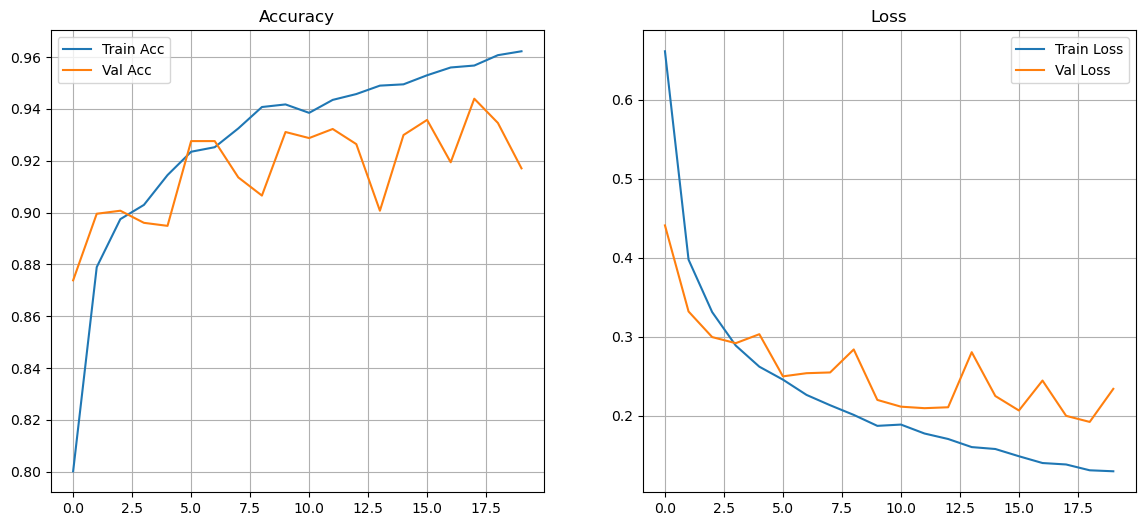

In [1]:
import json
import matplotlib.pyplot as plt

# JSON dosyasindan verileri oku
try:
    with open('muhammed_history.json', 'r') as f:
        history = json.load(f)
    
    print("Grafik verileri dosyadan yuklendi.")
    
    plt.figure(figsize=(14, 6))
    
    # Accuracy Grafigi
    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss Grafigi
    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.show()

except FileNotFoundError:
    print("HATA: muhammed_history.json dosyasi bulunamadi. Egitim henuz yapilmamis olabilir.")

Test islemi icin hazirlik yapiliyor...
Model agirliklari basariyla yuklendi.
Test seti analiz ediliyor...

SINIFLANDIRMA RAPORU
              precision    recall  f1-score   support

      glioma     0.9649    0.8594    0.9091       192
  meningioma     0.8564    0.9105    0.8827       190
     notumor     0.9693    0.9806    0.9750       258
   pituitary     0.9509    0.9771    0.9638       218

    accuracy                         0.9371       858
   macro avg     0.9354    0.9319    0.9326       858
weighted avg     0.9387    0.9371    0.9369       858



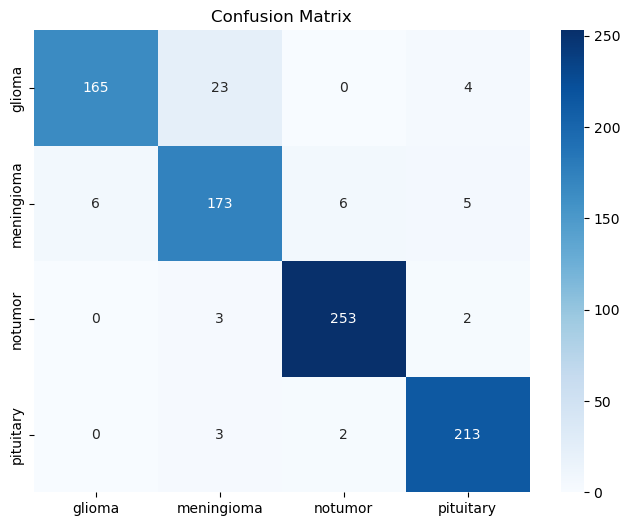

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os
import gc

# Hafiza Temizligi
gc.collect()
torch.cuda.empty_cache()

# Ayarlar
DATA_PATH = r"C:\Users\ArdaOlmez\Desktop\others\projects\python\datasets\brain_tumor_dataset-2\training"
BATCH_SIZE = 16
IMG_SIZE = 224
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Test islemi icin hazirlik yapiliyor...")

# Veri Setini Tekrar Tanimla (Sadece Test Icin)
data_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

full_dataset = datasets.ImageFolder(DATA_PATH, transform=data_transforms)
total_len = len(full_dataset)
train_len = int(0.7 * total_len)
val_len = int(0.15 * total_len)
test_len = total_len - train_len - val_len

# Seed ayni oldugu icin split ayni olacaktir
torch.manual_seed(213)
_, _, test_data = torch.utils.data.random_split(
    full_dataset, [train_len, val_len, test_len],
    generator=torch.Generator().manual_seed(213)
)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

# Modeli Kur
model = models.resnet50(weights=None)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)
model = model.to(device)

# Agirliklari Dosyadan Yukle
try:
    model.load_state_dict(torch.load('Muhammed_ResNet50_Final.pth', map_location=device))
    print("Model agirliklari basariyla yuklendi.")
    
    model.eval()
    all_preds = []
    all_labels = []
    
    print("Test seti analiz ediliyor...")
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Rapor
    print("\nSINIFLANDIRMA RAPORU")
    # digits=4 parametresi virgulden sonra 4 basamak gosterir
    print(classification_report(all_labels, all_preds, target_names=full_dataset.classes, digits=4))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=full_dataset.classes, yticklabels=full_dataset.classes)
    plt.title('Confusion Matrix')
    plt.show()

except FileNotFoundError:
    print("HATA: Muhammed_ResNet50_Final.pth dosyasi bulunamadi.")